# Zero deforestation mission

## Labels:

**0**: "Plantation". Network of rectangular plantation blocks.

**1**: "Grassland/Shrubland". Large homogeneous areas with few trees.

**2**: "Smallholder Agriculture": Small scale area, in wich you can find deforestation covered by agriculture.

In [1]:
# Importing modules 
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

np.random.seed(1)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

display(df_test.head(2))

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,train_test_data/test/69.png
1,-8.059785,113.053791,2007,train_test_data/test/469.png


In [3]:
def calc_ndvi(image):
    b, g, r = cv2.split(image)
    bottom = (r.astype(float) + b.astype(float))
    bottom[bottom==0] = 0.01
    ndvi = (b.astype(float) - r) / bottom
    return ndvi

In [4]:
# Process training data.
train_images = []
train_path = df_train["example_path"].to_numpy()

for filename in train_path:
    img = cv2.imread(filename)

    sigma = 0.33
    v = np.median(img)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    canny_edge = cv2.Canny(img, lower, upper)
    img = cv2.applyColorMap(canny_edge, cv2.COLORMAP_PINK)
    
    train_images.append(img)

train_images = np.array(train_images)
train_images.shape

(1714, 332, 332, 3)

In [5]:
# Process test data.
test_images = []
test_path = df_test["example_path"].to_numpy()

for filename in test_path:
    img = cv2.imread(filename)

    sigma = 0.33
    v = np.median(img)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    canny_edge = cv2.Canny(img, lower, upper)
    img = cv2.applyColorMap(canny_edge, cv2.COLORMAP_PINK)

    test_images.append(img)

test_images = np.array(test_images)
test_images.shape

(635, 332, 332, 3)

In [6]:
# train_images = train_images.reshape(1714, 110224)
# test_images = test_images.reshape(635, 110224)

Here we remove all the attributes for the data CSVs, so we only work with the label. (Currently).

We also convert 0 to [1 0 0], 1 to [0 1 0], and 2 to [0 0 1]. Therefore, we can translate the ML algorithm into a multiple binary classification problem.

In [7]:
df_train_label = df_train.pop("label")
df_train_label = pd.get_dummies(df_train_label).values

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_images, df_train_label, random_state=1234)

So now, we have:

**X_train**: Images for training. (TRAINING)

**X_val**: Images for validating the model. (VALIDATION)


**y_train**: Labels of the training images, so we can train. (TRAINING)

**y_val**: Labels of the validation set, so we can compare the results we predicted over X_val. (VALIDATION - F1 SCORE)


**test_images**: Like X_train or X_val, but for the final answer of the challenge (We don't know the labels).

In [9]:
X_train = X_train / 255
X_val = X_val / 255
# display(X_train.min())
# display(X_train.max())

In [10]:
train_samples = X_train.shape[0]
val_samples = X_val.shape[0]

[0 0 1]


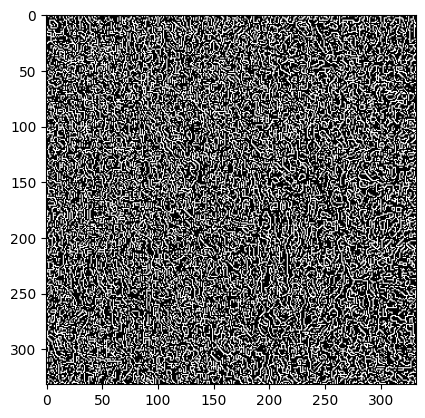

In [11]:
# Let's plot one of our examples.
print(df_train_label[5])
plt.imshow(train_images[5])

[1 0 0]


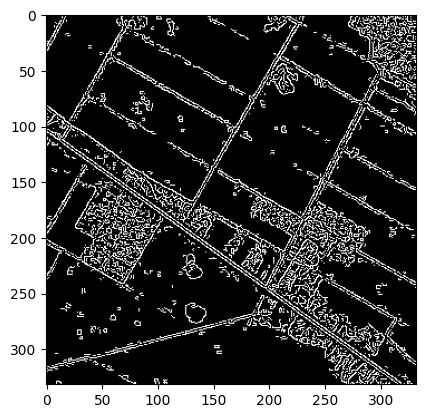

In [12]:
# Let's see a different one.
print(df_train_label[100])
plt.imshow(train_images[100])

In [13]:
# Sequential model.

model = Sequential()
model.add(Conv2D(kernel_size=(3,3), filters=32, activation='tanh', input_shape=(332,332,3,)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))

model.add(Flatten())

model.add(Dense(20,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(3,activation = 'softmax'))
    
model.compile(
              loss='categorical_crossentropy', 
              metrics=['acc'],
              optimizer='adam'
             )

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 330, 330, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 328, 328, 30)      8670      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 164, 164, 30)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 162, 162, 30)      8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 81, 81, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 79, 79, 30)        8130      
_________________________________________________________________
flatten (Flatten)            (None, 187230)            0

In [15]:
# Training the model.
batch_size = 32
history = model.fit(X_train, y_train, epochs=15, steps_per_epoch=train_samples/batch_size, validation_steps=val_samples/batch_size, validation_data=(X_val, y_val))
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/15
40/40 [==============================] - 13s 202ms/step - loss: 1.5410 - acc: 0.4249 - val_loss: 1.0050 - val_acc: 0.4476
Epoch 2/15


ResourceExhaustedError:  OOM when allocating tensor with shape[32,30,328,328] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/max_pooling2d/MaxPool/MaxPoolGrad (defined at C:\Users\danil\AppData\Local\Temp\ipykernel_4292\394405220.py:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1017]

Function call stack:
train_function


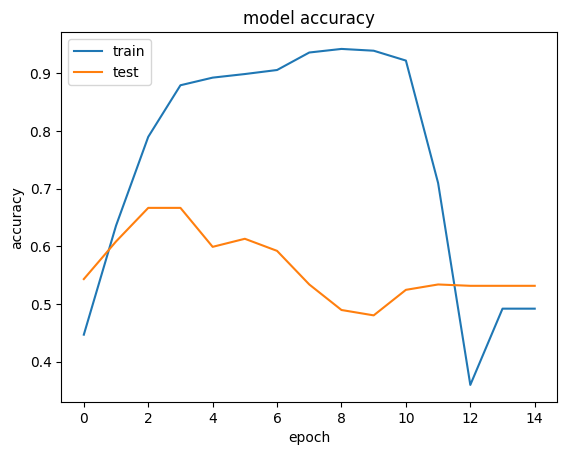

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()